<a href="https://colab.research.google.com/github/pnabende/acholi-corpora/blob/master/vgg_resnet_from_hvh_for_aedes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [3]:
import os

# Specify the path to your dataset
fpath = "/content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/training"
dataset_path = fpath

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

Number of classes: 2


In [4]:
img_size = 224
batch_size =100

ffpath="/content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/training"
fpath = "/content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/validation"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'fpath' is the path to your dataset and 'batch_size' is defined
"""
datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    validation_split=0.2,
    rotation_range=30,
    horizontal_flip=True
)
"""
datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2)

train_gen = datagen.flow_from_directory(
    ffpath,
    target_size=(224, 224),
    subset="training",
    class_mode='categorical',
    batch_size=batch_size
)

valid_gen = datagen.flow_from_directory(
    ffpath,
    target_size=(224, 224),
    batch_size=100,
    subset='validation',
    class_mode='categorical'
)

# For test data
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    fpath,
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 819 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = '/content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.6300 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/best_model_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 662s 80s/step - loss: 0.6645 - accuracy: 0.6300 - val_loss: 1.4477 - val_accuracy: 0.5000
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.7253 
Epoch 2: val_accuracy did not improve from 0.50000
9/9 [==============================] - 130s 16s/step - loss: 0.5447 - accuracy: 0.7253 - val_loss: 1.0356 - val_accuracy: 0.5000
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.7521 
Epoch 3: val_accuracy did not improve from 0.50000
9/9 [==============================] - 132s 15s/step - loss: 0.5056 - accuracy: 0.7521 - val_loss: 1.0272 - val_accuracy: 0.5000
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.7888 
Epoch 4: val_accuracy improved from 0.50000 to 0.50980, saving model to /content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/best_model_resnet.h5


In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('/content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/best_model_resnet.h5')

train_score = model.evaluate(train_gen, steps=len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps=len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 72s 60s/step - loss: 0.5590 - accuracy: 0.7056
Train Loss:  0.446027010679245
Train Accuracy:  0.8021978139877319
--------------------
Validation Loss:  0.64083331823349
Validation Accuracy:  0.6666666865348816
--------------------
Test Loss:  0.5590264201164246
Test Accuracy:  0.7055555582046509


In [8]:
model = load_model('/content/drive/MyDrive/research/research-grants-successful/2023-ahumain/2024-belgium-training/week-2/nonaugmented-data/original-aedes-data/best_model_resnet.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-8-316b157a9664>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0]


In [10]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[74 16]
 [37 53]]
              precision    recall  f1-score   support

           1       0.67      0.82      0.74        90
           2       0.77      0.59      0.67        90

    accuracy                           0.71       180
   macro avg       0.72      0.71      0.70       180
weighted avg       0.72      0.71      0.70       180



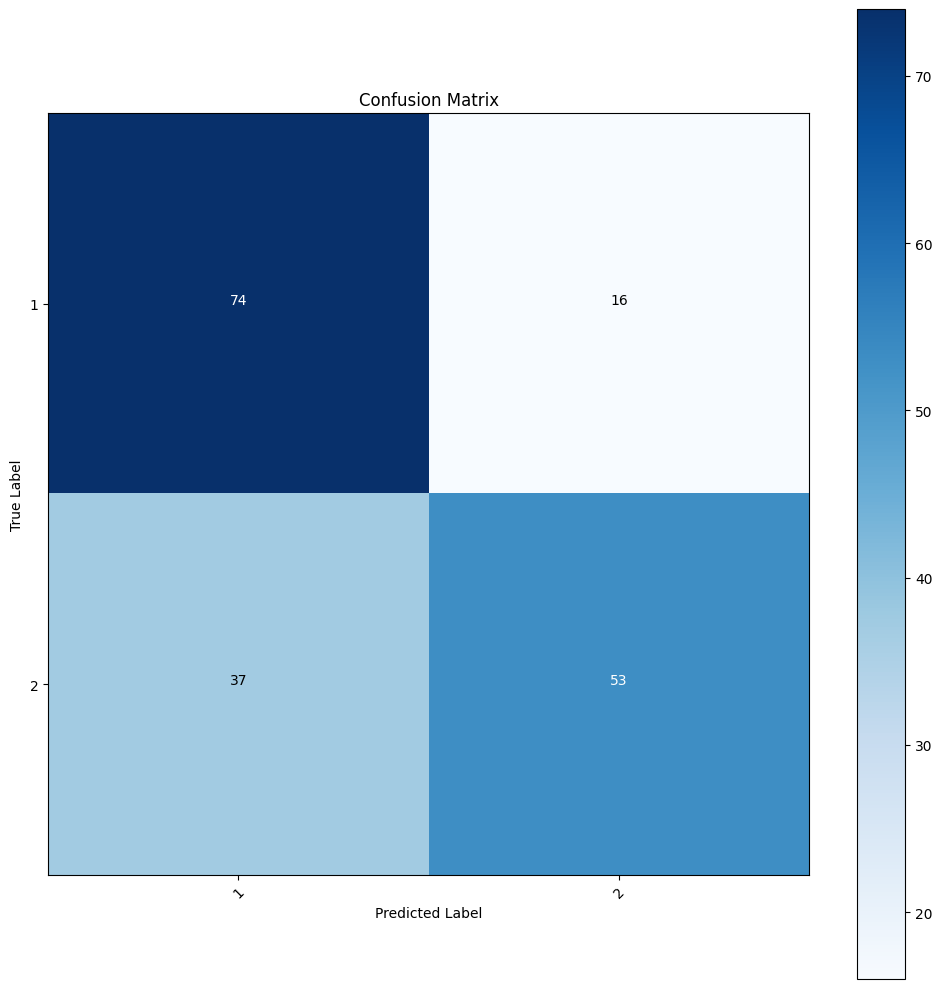

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['1','2']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))